In [1]:
import pickle
import os

import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from dataset.dataset import load_data
from dataset.utils import *
import matplotlib.pyplot as plt

from models.vgg import *

torch.set_printoptions(sci_mode=False)

import lrp
from models.converter import convert

from PIL import Image

/home/jack/anaconda3/envs/explainable-concept-bottleneck/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
if torch.cuda.is_available():
    print("Device:", device, torch.cuda.get_device_name(0))
else:
    print("Device:", device)

Device: cuda:0 NVIDIA GeForce GTX 1650 Ti


In [3]:
# Joint Model
def ModelXtoCtoY(n_class_attr, pretrained, freeze, num_classes, n_attributes, expand_dim, use_relu, use_sigmoid, train=True, **kwargs):
	vgg_model = vgg16_bn(pretrained=pretrained, num_classes=num_classes, n_attributes=n_attributes, bottleneck=True, expand_dim=expand_dim, train=train, **kwargs)
	model1 = x_to_c_model(freeze=freeze, model=vgg_model)
	if n_class_attr == 3:
		model2 = MLP(input_dim=n_attributes * n_class_attr, num_classes=num_classes, expand_dim=expand_dim, train=train)
	else:
		model2 = MLP(input_dim=n_attributes, num_classes=num_classes, expand_dim=expand_dim, train=train)
	return End2EndModel(model1, model2, use_relu, use_sigmoid, n_class_attr)

In [4]:
use_relu = False
use_sigmoid = False
freeze = False
expand_dim = 0
pretrained = False
train = True
n_class_attr = 2

In [6]:
# CBM dataset split and model (112 class level concpts)

N_CONCEPT = 112

val_split = pickle.load(open("./dataset/CUB/dataset_splits/CBM_dataset_split/test.pkl", "rb"))
train_split = pickle.load(open("./dataset/CUB/dataset_splits/CBM_dataset_split/train.pkl", "rb"))
val_loader = load_data("./dataset/CUB/dataset_splits/CBM_dataset_split/val.pkl", 16, image_dir='dataset/CUB/data/images', return_orig=True)
train_loader = load_data("./dataset/CUB/dataset_splits/CBM_dataset_split/train.pkl", 16, image_dir='dataset/CUB/data/images')

class_index_to_string = IndexToString("./dataset/CUB/data/classes.txt", classes=True)
concept_index_to_string = IndexToString("./dataset/CUB/dataset_splits/CBM_dataset_split/attributes.txt")

XtoCtoY_model = ModelXtoCtoY(n_class_attr=n_class_attr, pretrained=pretrained, num_classes=200, n_attributes=112, expand_dim=expand_dim, freeze=freeze, use_relu=use_relu, use_sigmoid=use_sigmoid, train=train)
XtoCtoY_model.load_state_dict(torch.load("./saves/CBM_paper/state_dict/independant_seed3.pth"))
XtoCtoY_model.to(device)
XtoCtoY_model.eval()

print("model loaded")

model loaded


In [ ]:
# explanable CBM dataset split and model (312 sample level concpts)

N_CONCEPT = 312

val_split = pickle.load(open("./dataset/CUB/explainable_CUB_dataset_split_train_val/val.pkl", "rb"))
train_split = pickle.load(open("./dataset/CUB/explainable_CUB_dataset_split_train_val/train.pkl", "rb"))
val_loader = load_data("./dataset/CUB/explainable_CUB_dataset_split_train_val/val.pkl", 16, image_dir='dataset/CUB/data/images', return_orig=True)
train_loader = load_data("./dataset/CUB/explainable_CUB_dataset_split_train_val/train.pkl", 16, image_dir='dataset/CUB/data/images')

class_index_to_string = IndexToString("./dataset/CUB/data/classes.txt", classes=True)
concept_index_to_string = IndexToString("./dataset/CUB/data/attributes.txt")

XtoCtoY_model = ModelXtoCtoY(n_class_attr=n_class_attr, pretrained=False, num_classes=200, n_attributes=312, expand_dim=0, freeze=False, use_relu=False, use_sigmoid=False, train=True)
XtoCtoY_model.load_state_dict(torch.load("./saves/vgg/state_dict/joint_explainable_dataset.pth"))
XtoCtoY_model.to(device)
XtoCtoY_model.eval()

print("model loaded")

In [7]:
IMG_SIZE =  299
training_transform = transforms.Compose([
    transforms.ColorJitter(brightness=32/255, saturation=(0.5, 1.5)),
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), #implicitly divides by 255
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [2, 2, 2])
    #transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ], std = [ 0.229, 0.224, 0.225 ]),
    ])

other_transform = transforms.Compose([
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(), #implicitly divides by 255
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [2, 2, 2])
    #transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ], std = [ 0.229, 0.224, 0.225 ]),
    ])

In [8]:
##### https://github.com/fhvilshoj/TorchLRP/blob/74253a1be05f0be0b7c535736023408670443b6e/examples/visualization.py#L60
def heatmap(X, cmap_name="seismic"):
	cmap = plt.cm.get_cmap(cmap_name)

	if X.shape[1] in [1, 3]:  # move channel index to end + convert to np array
		X = X.permute(0, 2, 3, 1).detach().cpu().numpy()
	if isinstance(X, torch.Tensor):  # convert tensor to np array
		X = X.detach().cpu().numpy()

	shape = X.shape
	tmp = X.sum(axis=-1) # Reduce channel axis

	tmp = project(tmp, output_range=(0, 255)).astype(int)
	tmp = cmap(tmp.flatten())[:, :3].T
	tmp = tmp.T

	shape = list(shape)
	shape[-1] = 3
	return tmp.reshape(shape).astype(np.float32)


def project(X, output_range=(0, 1)):
	absmax = np.abs(X).max(axis=tuple(range(1, len(X.shape))), keepdims=True)
	X /= absmax + (absmax == 0).astype(float)
	X = (X+1) / 2. # range [0, 1]
	X = output_range[0] + X * (output_range[1] - output_range[0]) # range [x, y]
	return X

In [9]:
XtoC_model = convert(XtoCtoY_model.first_model).to(device)

True image size (channels, width, height): torch.Size([3, 299, 299])
True  image label: Brewer_Blackbird
True  image concepts: tensor([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0.])


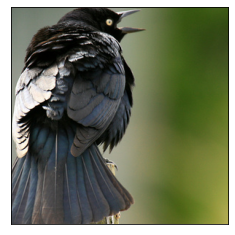

In [10]:
imageId = 9

images, labels, concepts, original_imgs = next(iter(val_loader))
image, label = images[imageId].to(device), labels[imageId].to(device)

# print / show input
print("True image size (channels, width, height):", image.size())
print("True  image label:", class_index_to_string(label.item()))
print("True  image concepts:", concepts[imageId])

plt.xticks([])
plt.yticks([])
plt.imshow(original_imgs[imageId].squeeze().permute(1, 2, 0))
plt.show()

In [11]:
image, label = images[imageId].to(device), labels[imageId].to(device)
image = image.unsqueeze(0)
image.requires_grad_(True)
image.grad = None

# get model prediction and LRP map for classification
prediction = XtoCtoY_model(image)
pred = prediction[0].max(1, keepdim=True)[1]

print("Predicted image label:", class_index_to_string(pred.item()))
pred_concepts_readable = torch.nn.Sigmoid()(prediction[1])
print("Predicted concepts:", pred_concepts_readable)

# print concept as string if prediction is >= 0.5
for idx, i in enumerate(pred_concepts_readable[0]):
    if i.item() >= 0.5:
        print(idx, concept_index_to_string(idx), i.item())

Predicted image label: Brewer_Blackbird
Predicted concepts: tensor([[    0.0000,     0.0000,     0.9453,     0.0001,     0.0001,     0.0000,
             0.0000,     0.9976,     0.0003,     0.0000,     0.0001,     0.0000,
             0.0000,     0.9997,     0.0000,     0.0000,     0.0000,     0.0001,
             0.0000,     0.9995,     0.0005,     0.0000,     0.9816,     0.0000,
             0.0001,     0.0001,     0.0001,     0.0000,     0.9987,     0.0000,
             0.0000,     0.0003,     0.0000,     0.0000,     0.9999,     0.0000,
             0.0000,     0.0000,     0.0039,     0.0000,     0.0000,     0.0000,
             0.9993,     0.0002,     0.0000,     0.0000,     0.0000,     0.9997,
             0.0001,     0.0000,     0.9915,     0.0033,     0.9905,     0.0008,
             0.0000,     0.0000,     0.0000,     0.9998,     0.0000,     0.0000,
             0.0000,     0.9998,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     0.9989,     0.0000,     

has_bill_shape::dagger


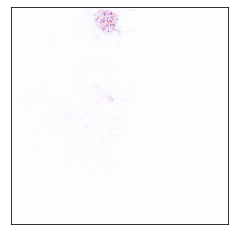

has_bill_shape::hooked_seabird


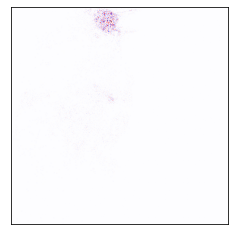

has_bill_shape::all-purpose


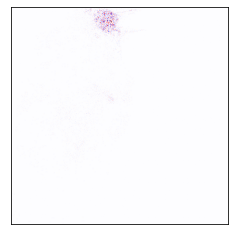

has_bill_shape::cone


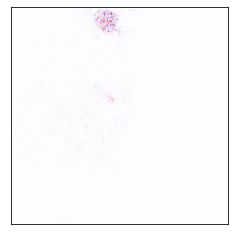

has_wing_color::brown


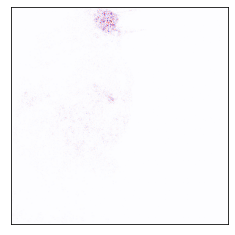

has_wing_color::grey


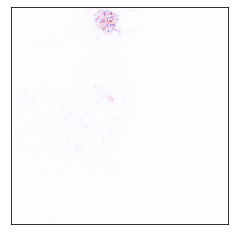

has_wing_color::yellow


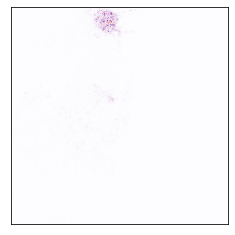

has_wing_color::black


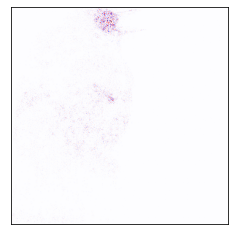

has_wing_color::white


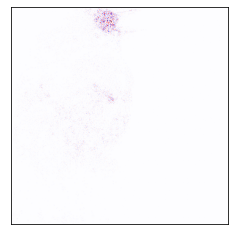

has_wing_color::buff


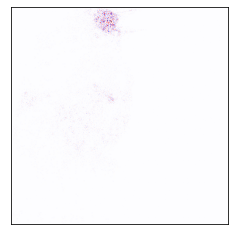

has_upperparts_color::brown


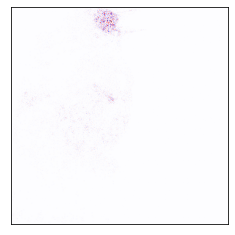

has_upperparts_color::grey


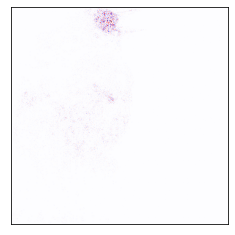

has_upperparts_color::yellow


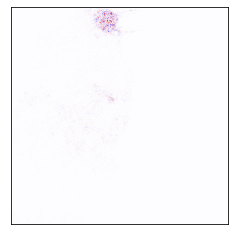

has_upperparts_color::black


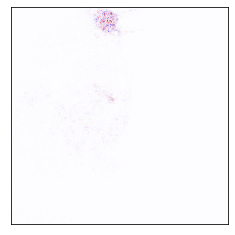

has_upperparts_color::white


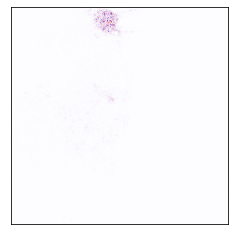

In [12]:
image, label = images[imageId].to(device), labels[imageId].to(device)
#image, label = images.to(device), labels.to(device)
image = image.unsqueeze(0)
image.requires_grad_(True)
image.grad = None  # Reset gradient

pred_concepts = XtoC_model.forward(image, explain=True, rule="alpha1beta0")
pred_concepts = XtoC_model.forward(image, explain=True, rule="alpha2beta1")
pred_concepts = XtoC_model.forward(image, explain=True, rule="epsilon")
#pred_concepts = XtoC_model.forward(image, explain=True, rule="gradient")

# get saliecy maps for a subset of concepts (first 15)
for i in range(15):
    filter_out = torch.zeros_like(pred_concepts)
    filter_out[:,i] += 1

    # Get the gradient of each input
    image_gradient = torch.autograd.grad(
        pred_concepts,
        image,
        grad_outputs=filter_out,
        retain_graph=True)[0]


    attr = heatmap(image_gradient, cmap_name='seismic')
    
    print(concept_index_to_string(i))

    plt.xticks([])
    plt.yticks([])
    #plt.title(label=concept_index_to_string(i), fontsize=15)
    plt.imshow(attr.squeeze(), cmap='seismic')
    #plt.savefig(f'temp/{i}.png')
    plt.show()

    plt.close()

In [13]:
XtoC_model_1 = []
XtoC_model_2 = []
XtoC_model_3 = []

for idx, m in enumerate(XtoC_model.children()):
    if idx < 18:
        XtoC_model_1.append(m)
    elif idx < 29:
        XtoC_model_2.append(m)
    else:
        XtoC_model_3.append(m)

XtoC_model_1 = lrp.Sequential(*XtoC_model_1)
XtoC_model_2 = lrp.Sequential(*XtoC_model_2)
XtoC_model_3 = lrp.Sequential(*XtoC_model_3)

XtoC_model_1.to(device)
XtoC_model_2.to(device)
XtoC_model_3.to(device)

print(XtoC_model_1)
print(XtoC_model_2)
print(XtoC_model_3)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU()
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, momentum

has_primary_color::black


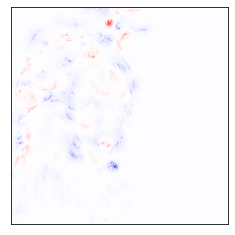

has_upper_tail_color::black


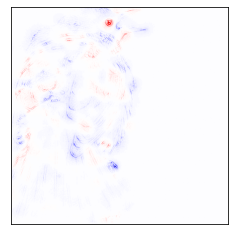

has_bill_color::black


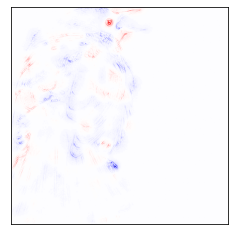

has_forehead_color::black


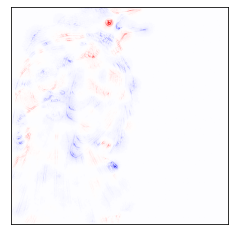

has_under_tail_color::black


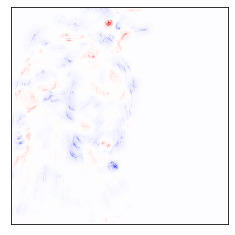

has_upperparts_color::black


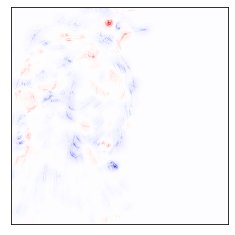

has_throat_color::black


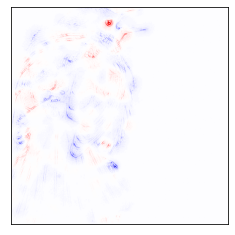

has_belly_color::black


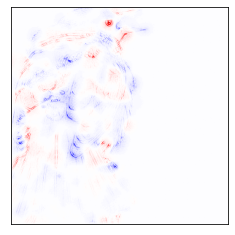

has_underparts_color::black


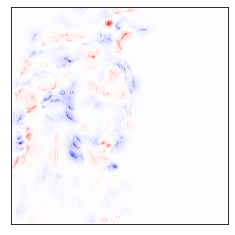

has_breast_color::black


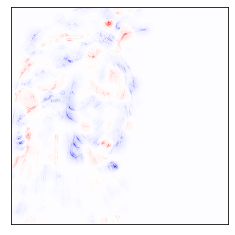

has_tail_pattern::solid


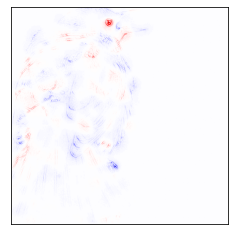

has_nape_color::black


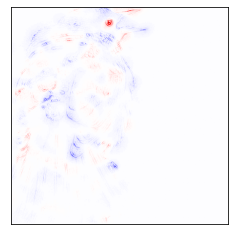

has_back_color::black


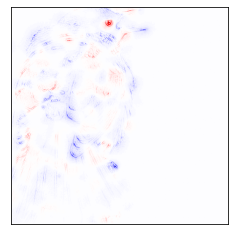

has_wing_pattern::solid


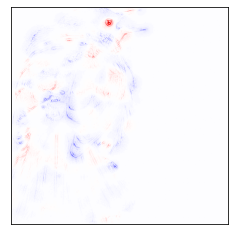

has_back_pattern::solid


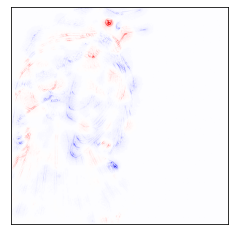

has_crown_color::black


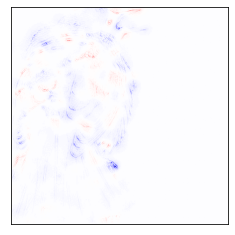

has_wing_color::black


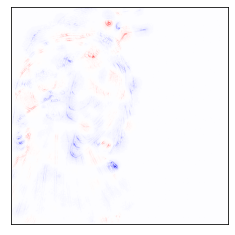

has_leg_color::black


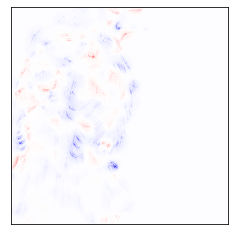

has_eye_color::black


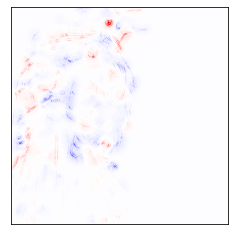

has_bill_length::shorter_than_head


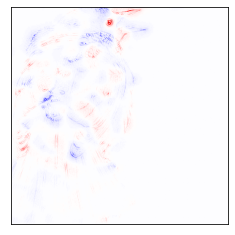

has_belly_pattern::solid


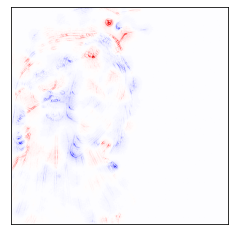

has_breast_pattern::solid


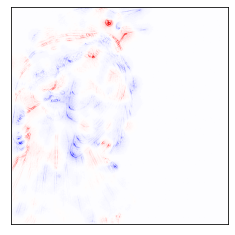

has_size::small_(5_-_9_in)


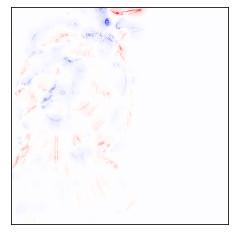

has_bill_shape::all-purpose


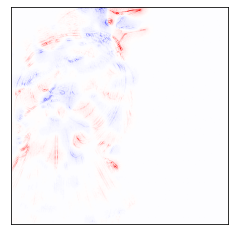

has_wing_shape::rounded-wings


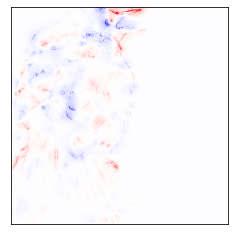

In [14]:
image, label = images[imageId].to(device), labels[imageId].to(device)
#image, label = images.to(device), labels.to(device)
image = image.unsqueeze(0)
image.requires_grad_(True)
image.grad = None  # Reset gradient

output_1 = XtoC_model_1.forward(image, explain=True, rule="alpha1beta0")
output_2 = XtoC_model_2.forward(output_1, explain=True, rule="epsilon")
pred_concepts = XtoC_model_3.forward(output_2, explain=True, rule="gradient")

"""
# get saliecy maps for a subset of concept (first 15)
for i in range(15):
    filter_out = torch.zeros_like(pred_concepts)
    filter_out[:,i] += 1

    # Get the gradient of each input
    image_gradient = torch.autograd.grad(
        pred_concepts,
        image,
        grad_outputs=filter_out,
        retain_graph=True)[0]


    attr = heatmap(image_gradient, cmap_name='seismic')
    
    print(concept_index_to_string(i))

    plt.xticks([])
    plt.yticks([])
    #plt.title(label=concept_index_to_string(i), fontsize=15)
    plt.imshow(attr.squeeze(), cmap='seismic')
    #plt.savefig(f'temp/{i}.png')
    plt.show()

    plt.close()
"""
    
    
# get saliecy maps for top 5 concepts
pred_precent_concepts = []
for idx, i in enumerate(pred_concepts_readable[0]):
    if i.item() >= 0.5:
        pred_precent_concepts.append((idx, i.item()))

pred_precent_concepts = sorted(pred_precent_concepts, key=lambda x: -x[1])

for i in pred_precent_concepts:
    filter_out = torch.zeros_like(pred_concepts)
    filter_out[:,i[0]] += 1

    # Get the gradient of each input
    image_gradient = torch.autograd.grad(
        pred_concepts,
        image,
        grad_outputs=filter_out,
        retain_graph=True)[0]


    attr = heatmap(image_gradient, cmap_name='seismic')
    
    print(concept_index_to_string(i[0]))

    plt.xticks([])
    plt.yticks([])
    #plt.title(label=concept_index_to_string(i), fontsize=15)
    plt.imshow(attr.squeeze(), cmap='seismic')
    #plt.savefig(f'temp/{i[0]}.png')
    plt.show()

    plt.close() 


## Average concept saliency maps

Saliency maps are grouped together by name and then averaged.

In [35]:
# (group name, (start id, end id))
# CUB concept groups
if N_CONCEPT == 112:
    # CBM paper dataset split concept groups
    concept_groups = [
        ("bill_shape", (1, 4)),
        ("wing_color", (5, 10)),
        ("upperparts_color", (11, 23)),
        ("breast_pattern", (24, 25)),
        ("back_color", (26, 31)),
        ("tail_shape", (32, 32)),
        ("upper_tail_color", (33, 37)),
        ("head_pattern", (38, 39)),
        ("breast_color", (40, 45)),
        ("throat_color", (46, 50)),
        ("eye_color", (51, 52)),
        ("bill_length", (53, 54)),
        ("forehead_color", (55, 59)),
        ("under_tail_color", (60, 64)),
        ("nape_color", (65, 70)),
        ("belly_color", (71, 77)),
        ("wing_shape", (78, 78)),
        ("size", (79, 81)),
        ("shape", (82, 84)),
        ("back_pattern", (85, 87)),
        ("tail_pattern", (88, 90)),
        ("primary_color", (91, 96)),
        ("leg_color", (97, 99)),
        ("bill_color", (100, 103)),
        ("crown_color", (104, 109)),
        ("wing_pattern", (110, 112))
    ]
else: 
    concept_groups = [
        ("bill_shape", (1, 9)),
        ("wing_color", (10, 24)),
        ("upperparts_color", (25, 54)),
        ("breast_pattern", (55, 58)),
        ("back_color", (59, 73)),
        ("tail_shape", (74, 79)),
        ("upper_tail_color", (80, 94)),
        ("head_pattern", (95, 105)),
        ("breast_color", (106, 120)),
        ("throat_color", (121, 135)),
        ("eye_color", (136, 149)),
        ("bill_length", (150, 152)),
        ("forehead_color", (153, 167)),
        ("under_tail_color", (168, 182)),
        ("nape_color", (183, 197)),
        ("belly_color", (198, 212)),
        ("wing_shape", (213, 217)),
        ("size", (218, 222)),
        ("shape", (223, 236)),
        ("back_pattern", (237, 240)),
        ("tail_pattern", (241, 244)),
        ("belly_pattern", (245, 248)),
        ("primary_color", (249, 263)),
        ("leg_color", (264, 278)),
        ("bill_color", (279, 293)),
        ("crown_color", (294, 308)),
        ("wing_pattern", (309, 312))
    ]


In [36]:
for group in concept_groups:
    image, label = images[imageId].to(device), labels[imageId].to(device)
    #image, label = images.to(device), labels.to(device)
    image = image.unsqueeze(0)
    image.requires_grad_(True)
    image.grad = None  # Reset gradient

    output_1 = XtoC_model_1.forward(image, explain=True, rule="alpha1beta0")
    output_2 = XtoC_model_2.forward(output_1, explain=True, rule="epsilon")
    pred_concepts = XtoC_model_3.forward(output_2, explain=True, rule="gradient")
    
    group_grads = []

    # get saliecy maps for each concept group
    for i in range(group[1][0] - 1, group[1][1]):  # start id -> end id (is's start from 0)
        filter_out = torch.zeros_like(pred_concepts)
        filter_out[:,i] += 1

        # Get the gradient of each input
        image_gradient = torch.autograd.grad(
            pred_concepts,
            image,
            grad_outputs=filter_out,
            retain_graph=True)[0]
        
        group_grads.append(image_gradient)
        
    avg_attr = heatmap(torch.stack(group_grads).mean((0)), cmap_name='seismic')

    plt.xticks([])
    plt.yticks([])
    plt.title(label=group[0], fontsize=15)
    plt.imshow(avg_attr.squeeze(), cmap='seismic')
    plt.savefig(f'temp/{group[0]}.png')

    plt.close()